**Welcome to the Mini Challenge!**

In this notebook, your task is to explore and report on the decision-making process of a simple CNN model trained on an image classification task. The model, trained on a varient of the MNIST dataset (a 10-class classification problem), will be loaded below along with 10 example images.

Your goal is to apply various Explainable AI (XAI) techniques to understand how the model makes decisions. Keep in mind that some XAI methods are data-agnostic. Just because you learned them in a different context doesn't mean they can't be applied to image data.

For details on grading, please refer to the "Proof of Performance" section in the EAI space.

In [1]:
import torch
import utils
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F
from utils import custom_cmap, normalize
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings

In [2]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Load the models best weights
model = SimpleCNN()
model.load_state_dict(torch.load('../models/challenge_model.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [3]:
# Load data and labels
challenge_images = np.load('../data/challenge_images.npy')
challenge_labels = np.load('../data/challenge_labels.npy')
print(f"Loaded challenge images: {challenge_images.shape}, labels: {challenge_labels.shape}")

Loaded challenge images: (10, 1, 28, 28), labels: (10,)


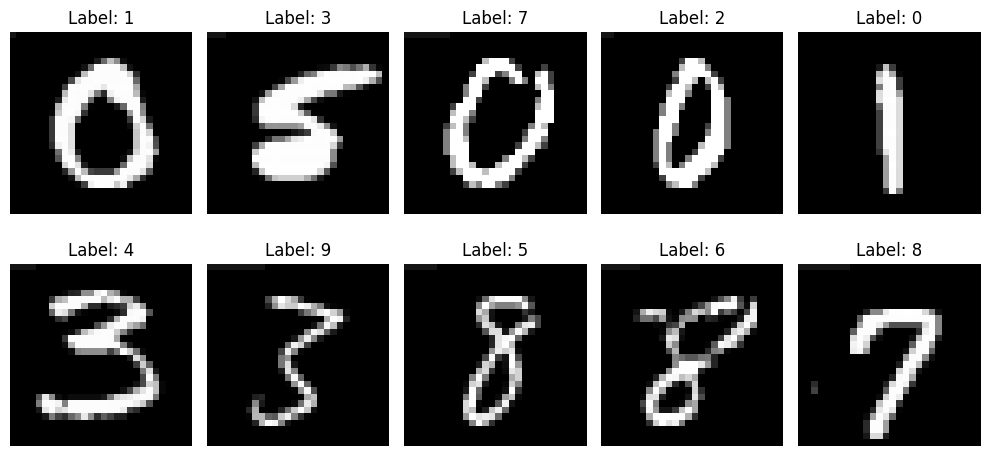

Challenge Labels: [1 3 7 2 0 4 9 5 6 8]


In [4]:
# Grid plot of the images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(challenge_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {challenge_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print challenge labels
print(f"Challenge Labels: {challenge_labels}")

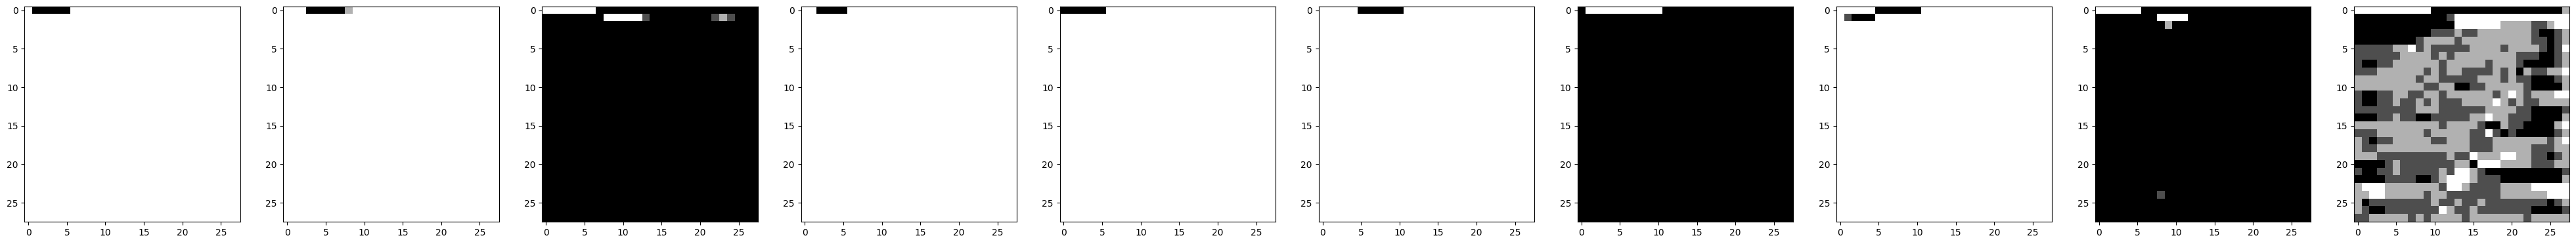

In [5]:
# Initialize Integrated Gradients
ig = IntegratedGradients(model)
# Plot Integrated Gradients reults from Captum library for all images
fig, axs = plt.subplots(1, challenge_images.shape[0], figsize=(5 * challenge_images.shape[0], 5))
for i, image in enumerate(challenge_images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).unsqueeze(0).float()
    target_class = int(challenge_labels[i])
    # Compute Integrated Gradients saliency map
    saliency_map = ig.attribute(input_tensor, target=target_class).squeeze().detach().numpy()
    # Plot integrated gradients saliency map 
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

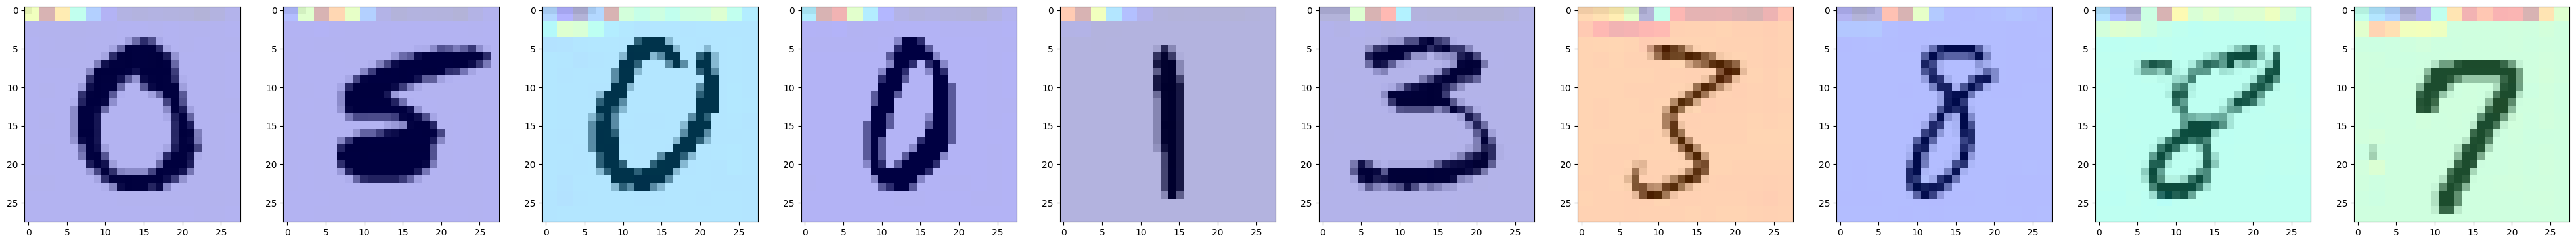

In [6]:
# Initialize Occlusion
occlusion = Occlusion(model)

# Plot occlusion reults for all images
fig, axs = plt.subplots(1, challenge_images.shape[0], figsize=(5 * challenge_images.shape[0], 5))
for i, image in enumerate(challenge_images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).unsqueeze(0).float()
    target_class = int(challenge_labels[i])
    # Compute the occlusion saliency map
    saliency_map = occlusion.attribute(
        input_tensor,
        strides=(1, 2, 2),  # Strides for sliding window across channels, height, width
        target=target_class,  # Target class index
        sliding_window_shapes=(1, 2, 2),  # Window size for occlusion (channels, height, width)
    )
    # Convert attributions to numpy for visualization
    saliency_map = saliency_map.squeeze().detach().numpy()

    # Plot integrated gradients saliency map 
    axs[i].imshow(utils.normalize(image.squeeze()), cmap='binary')
    axs[i].imshow(saliency_map, cmap='jet', alpha=0.3)

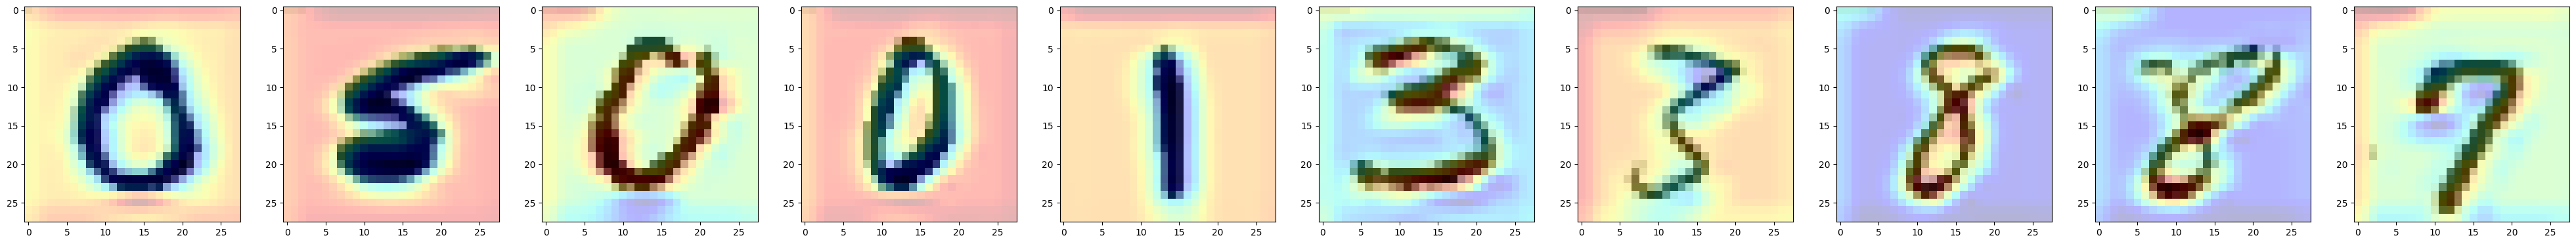

In [7]:
# Initialize LayerGradCam
lgc = LayerGradCam(model, model.conv2) 

# Plot LayerGradCam reults from Captum library for all images
fig, axs = plt.subplots(1, challenge_images.shape[0], figsize=(5 * challenge_images.shape[0], 5))
for i, image in enumerate(challenge_images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).unsqueeze(0).float() # shape (batch, channels, height, width)
    target_class = int(challenge_labels[i]) # Select the target class
    saliency_map = lgc.attribute(input_tensor, target=target_class)  
    # Upsample the attribution to the original image size
    saliency_map = torch.nn.functional.interpolate(
        saliency_map, size=(28, 28), mode="bilinear", align_corners=False)
    # Convert the upsampled attribution to numpy
    saliency_map = saliency_map.squeeze(0, 1).detach().numpy()
    # Plot original image and saliency map overlay
    axs[i].imshow(utils.normalize(image.squeeze()), cmap='binary')
    axs[i].imshow(saliency_map, cmap='jet', alpha=0.3)

3


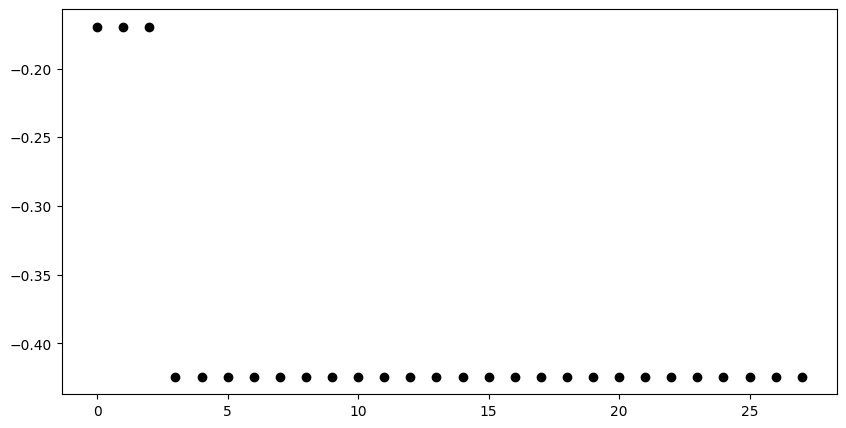

In [8]:
# Scatter plot of the images first row 
indx = 1
im = challenge_images[indx].squeeze()
plt.figure(figsize=(10, 5))
plt.scatter(range(len(im)), im[0,:], c='k')
print(challenge_labels[indx])

All the saliency maps indicate that the first row of the image, rather than the digit itself, is important. Upon closer inspection, it appears that the label has been encoded into the top row, with the number of saturated pixels corresponding to the label.
